In [22]:
import numpy as np
from sedpy.observate import load_filters
from sedpy.observate import Filter
from prospect import prospect_args
from prospect.fitting import fit_model
from prospect.io import write_results as writer
import matplotlib.pyplot as plt
from astropy import units as u

In [45]:
[x.wave_mean for x in filters]

[1528.0585558648577,
 3347.2785273633895,
 4736.376920312524,
 5256.111069692767,
 7972.961764025403,
 12409.620957882336,
 15324.468777262615,
 35378.510121992826,
 700165.56,
 996011.3,
 1585786.9,
 2461257.0,
 3455033.2,
 4931467.0]

In [213]:
run_params = {'verbose':False,
              'debug':False,
              'output_pickles': False,
              # dynesty Fitter parameters
              'nested_bound': 'multi', # bounding method
              'nested_sample': 'auto', # sampling method
              'nested_nlive_init': 400,
              'nested_nlive_batch': 200,
              'nested_bootstrap': 0,
              'nested_dlogz_init': 0.05,
              'nested_weight_kwargs': {"pfrac": 1.0},
              }

In [397]:
# --------------
# Model Definition
# --------------

def build_model(**kwargs):
    """Construct a model.  This method defines a number of parameter
    specification dictionaries and uses them to initialize a
    `models.sedmodel.SedModel` object.
    :param object_redshift:
        If given, given the model redshift to this value.
    :param add_dust: (optional, default: False)
        Switch to add (fixed) parameters relevant for dust emission.
    :param add_neb: (optional, default: False)
        Switch to add (fixed) parameters relevant for nebular emission, and
        turn nebular emission on.
    :param luminosity_distance: (optional)
        If present, add a `"lumdist"` parameter to the model, and set it's
        value (in Mpc) to this.  This allows one to decouple redshift from
        distance, and fit, e.g., absolute magnitudes (by setting
        luminosity_distance to 1e-5 (10pc))
    """
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors, sedmodel

    # --- Get a basic delay-tau SFH parameter set. ---
    # This has 5 free parameters:
    #   "mass", "logzsol", "dust2", "tage", "tau"
    # And two fixed parameters
    #   "zred"=0.1, "sfh"=4
    # See the python-FSPS documentation for details about most of these
    # parameters.  Also, look at `TemplateLibrary.describe("parametric_sfh")` to
    # view the parameters, their initial values, and the priors in detail.
    model_params = TemplateLibrary["parametric_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])

    model_params['tau']['isfree'] = False
    model_params['tau']['init'] = 1.0
    model_params['sf_start'] = {"N": 1, "isfree": False,
                           "init": 1.0, 
                            "units": "start of SF, Gyr"}


    model_params["lumdist"] = {"N": 1, "isfree": False,
                         "init": 1.0e-5, "units": "Mpc"}
    model_params['tage']['prior'] = priors.TopHat(mini=1.0, maxi=10.0)
    model_params['tage']['init'] = 5.0
    model_params['logzsol']['init'] = 0.2
    model_params['logzsol']['isfree'] = True
    model_params['logzsol']['prior'] = priors.TopHat(mini=-1.5, maxi=0.5)                                                                                                                                                                    
    model_params['mass']['prior'] = priors.TopHat(mini=1e7, maxi=1e13)
    # Set the dust and agn emission free                                                                                                                                                                                                      
                                                                                                                                                                                                 
    model_params['duste_gamma']['init'] = 0.01
    model_params['duste_qpah']['init'] = 3.5
    model_params['duste_umin']['init'] = 1.0                                                                                                                                                                





    # Complexify the dust attenuation                                                                                                                                                                                                         
    model_params["dust_type"] = {"N": 1, "isfree": False, "init": 0, "units": "FSPS index"} #power-law                                                                                                                                       \
                                                                                                                                                                                                                                              

    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["dust1"]  = {"N": 1, "isfree": True,
                     "init": 0.0, "prior" : priors.TopHat(mini=0.0, maxi=1.5),
                     "units": "optical depth towards young stars"}
    model_params["dust_index"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}
    model_params["dust_index1"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}

    # Now instantiate the model using this new dictionary of parameter specifications
    model = sedmodel.SedModel(model_params)

    return model

In [387]:
model_params["dust_type"] = {"N": 1, "isfree": False, "init": 1, "units": "FSPS index"} #MW                                                                                                                                              \
model_params["mrw"] = {"N": 1, "isfree": True,
                           "init": 1.0, "units": "The ratio of total to selective absorption which characterizes the MW extinction curve", 'prior' : priors.TopHat(mini=2.0, maxi=5.0)}
model_params['uvb'] = {'N': 1, 'isfree': True,
                           'init': 1.0, 'units':"characterizing the strength of the 2175A extinction feature with respect to the standard Cardelli et al. determination for the MW",
                           'prior': priors.TopHat(mini = 0.1, maxi=3.0)}





model_params["dust_type"] = {"N": 1, "isfree": False, "init": 2, "units": "FSPS index"} #Calzetti                                                                                                                                         
model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
model_params["dust1"] = {"N": 1, "isfree": False,
                         "init": 0.0, "units": "optical depth towards young stars"}



model_params["dust_type"] = {"N": 1, "isfree": False, "init": 4, "units": "FSPS index"} #Conroy & Kriek dust atten.                                                                                                                      \
                                                                                                                                                                                                                                              
model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
model_params["dust1"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "optical depth towards young stars",
                     "prior": priors.TopHat(mini=0.0, maxi=2.0)}
model_params["dust_index"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.5, maxi=0.7)}



model_params["dust_type"] = {"N": 1, "isfree": False, "init": 0, "units": "FSPS index"} #power-law                                                                                                                                       \
                                                                                                                                                                                                                                              

model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
model_params["dust1"]  = {"N": 1, "isfree": True,
                     "init": 0.0, "prior" : priors.TopHat(mini=0.0, maxi=1.5),
                     "units": "optical depth towards young stars"}
model_params["dust_index"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}
model_params["dust_index1"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}




NameError: name 'model_params' is not defined

In [1]:
# --------------                                                                                                                                                                                                                              
# OBS                                                                                                                                                                                                                                         
# --------------                                                                                                                                                                                                                              

# Here we are going to put together some filter names                                                                                                                                                                                         
galex = ['galex_FUV']
hst_wfc3_uv  = ['wfc3_uvis_f336w', 'wfc3_uvis_f475w','wfc3_uvis_f555w',  'wfc3_uvis_f814w']
#sdss = ['sdss_i0']                                                                                                                                                                                                                           
hst_wfc3_ir = ['wfc3_ir_f125w', 'wfc3_ir_f160w']
#spitzer_mips = ['spitzer_mips_24']                                                                                                                                                                                                           
#wise = ['wise_w4']                                                                                                                                                                                                                           
irac = ['spitzer_irac_ch1']
herschel_pacs = ['herschel_pacs_70', 'herschel_pacs_100', 'herschel_pacs_160']
herschel_spire = ['herschel_spire_250', 'herschel_spire_350', 'herschel_spire_500']




# All these filters are available in sedpy.  If you want to use other filters,                                                                                                                                                                
# add their transmission profiles to sedpy/sedpy/data/filters/ with appropriate                                                                                                                                                               
# names (and format)                                                                                                                                                                                                                          
filternames = (galex + hst_wfc3_uv + hst_wfc3_ir + irac + herschel_pacs + herschel_spire)

In [34]:
filters = load_filters(filternames)

In [15]:
filters[0]

<class 'sedpy.observate.Filter'>(galex_FUV)

In [127]:
def build_obs(**kwargs):
                                                                                                                                                                                                                               
    import fsps
    import astropy.units as u
    
    stellar_mass_formed = 1.e11
    sp = fsps.StellarPopulation(sfh=4,logzsol=0.0,dust_type=2,dust1=0.0,dust2=1.5)
    wav,spec=sp.get_spectrum(tage=9.0) #wav in Angstrom, spec in Lsun / Hz
    #wav = wav*u.Angstrom
    spec *= stellar_mass_formed #spec is normalized to 1 solar mass, scale to wanted stellar mass
    wav_m = wav * 1e-10 #Angstrom to m conversion                                                                                                                                                                                             
    wav_um = wav_m * 1e6
    
    spec_to_W = spec * 3.827e26  #now W/Hz                                                                                                                                                                                                
    #DL = Planck15.luminosity_distance(z).to(u.m)                                                                                                                                                                                             
    DL = (1.0e-5 * u.Mpc).to(u.m)
    conversion = (1./(4.*np.pi*(DL.value)**2)) * (1.0e26)
    to_flux = spec_to_W * conversion #now Jy                                                                                                                                                                                                 
    to_maggies = to_flux / 3631.

    filter_wavs = np.array([.15,  0.33519, .475, .555, .814, 1.2516, 1.52359, 3.56, 70., 100., 160., 250., 350., 500.]) #um                                                                                                 
    #filter_wavs = 
    flx = [None] * len(filter_wavs)
    flxe = [None] * len(filter_wavs)
    for i in range(0, len(filter_wavs)):
        flx[i] = to_maggies[(np.abs(wav_um - filter_wavs[i])).argmin()]
        flxe[i] = 0.1 * flx[i]
    flux_mag = np.asarray(flx)
    unc_mag = np.asarray(flxe)




    # Build output dictionary.                                                                                                                                                                                                                
    obs = {}                                                                                                                                                                    
    obs['filters'] = load_filters(filternames)                                                                                                                                                                                                               
    obs['maggies'] = flux_mag                                                                                                                                                             
    obs['maggies_unc'] = unc_mag                                                                                                                                                                                                      
    obs['phot_mask'] = np.isfinite(flux_mag)                                                                                                                                                                                                                   
    obs['wavelength'] = None


    return obs

In [395]:
def build_obs(**kwargs):
    sps = build_sps()
    mod = build_model()
    fake_obs = {'filters': load_filters(filternames), 'wavelength': None}

    # Change all of your model parameters for testing here
    mod.params['dust_type'] = 1 # non-Calzetti attenuation curve

    # Create your desired input free parameters here
    initial_theta = mod.initial_theta.copy()
    
    initial_theta[mod.theta_labels().index('dust2')] = 1.5 # more dust
    initial_theta[mod.theta_labels().index('logzsol')] = 0.0
    initial_theta[mod.theta_labels().index('tage')] = 2.0
    spec, mags, stellar_mass = mod.mean_model(initial_theta,sps=sps,obs=fake_obs)
    #print(mod.theta_labels(), initial_theta)
    obs = {}
    obs['maggies'] = mags  
    obs['filters'] = load_filters(filternames)                                                                                                                                                             
    obs['maggies_unc'] = mags * 0.1                                                                                                                                                                                                     
    obs['phot_mask'] = np.isfinite(mags)                                                                                                                                                                                                                   
    obs['wavelength'] = None
    
    return obs

In [217]:
def build_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous,
                       compute_vega_mags=compute_vega_mags)
    return sps

In [218]:
def build_noise(**extras):
    return None, None

In [111]:
def build_all(**kwargs):

    return (build_obs(**kwargs), build_model(**kwargs),
            build_sps(**kwargs), build_noise(**kwargs))

In [398]:
import time, sys
obs, model, sps, noise = build_all(**run_params)

run_params["sps_libraries"] = sps.ssp.libraries
#run_params["param_file"] = __file__

#print(model)

#if args.debug:
#    sys.exit()

#hfile = setup_h5(model=model, obs=obs, **run_params)
hfile = "power_delayed.h5"
output = fit_model(obs, model, sps, noise, **run_params)

writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

try:
    hfile.close()
except(AttributeError):
    pass

iter: 9526 | batch: 1 | nc: 8 | ncall: 49585 | eff(%): 19.230 | loglstar: -288.723 < -284.510 < -286.543 | logz: -302.125 +/-  0.195 | stop:  1.035     /anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
/anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/io/write_results.py:237: RuntimeWarning: Could not JSON serialize run_params, pickled instead
/anaconda3/lib/python3.6/site-packages/prospect-0.3.0-py3.6.egg/prospect/io/write_results.py:237: RuntimeWarning: Could not JSON serialize model_params, pickled instead


In [45]:
import prospect.io.read_results as pread
from astropy import uncertainty as unc
from astropy.visualization import quantity_support 

In [3]:
respower, obspower, _ = pread.results_from('/Users/sidneylower/Jupyter Scripts/power_delayed.h5')
resCal, obsCal, modCal = pread.results_from('/Users/sidneylower/Jupyter Scripts/Cal_delayed.h5')
resMW, obsMW, _ = pread.results_from('/Users/sidneylower/Jupyter Scripts/MW_delayed.h5')
resKC, obsKC, _ = pread.results_from('/Users/sidneylower/Jupyter Scripts/KC_delayed.h5')

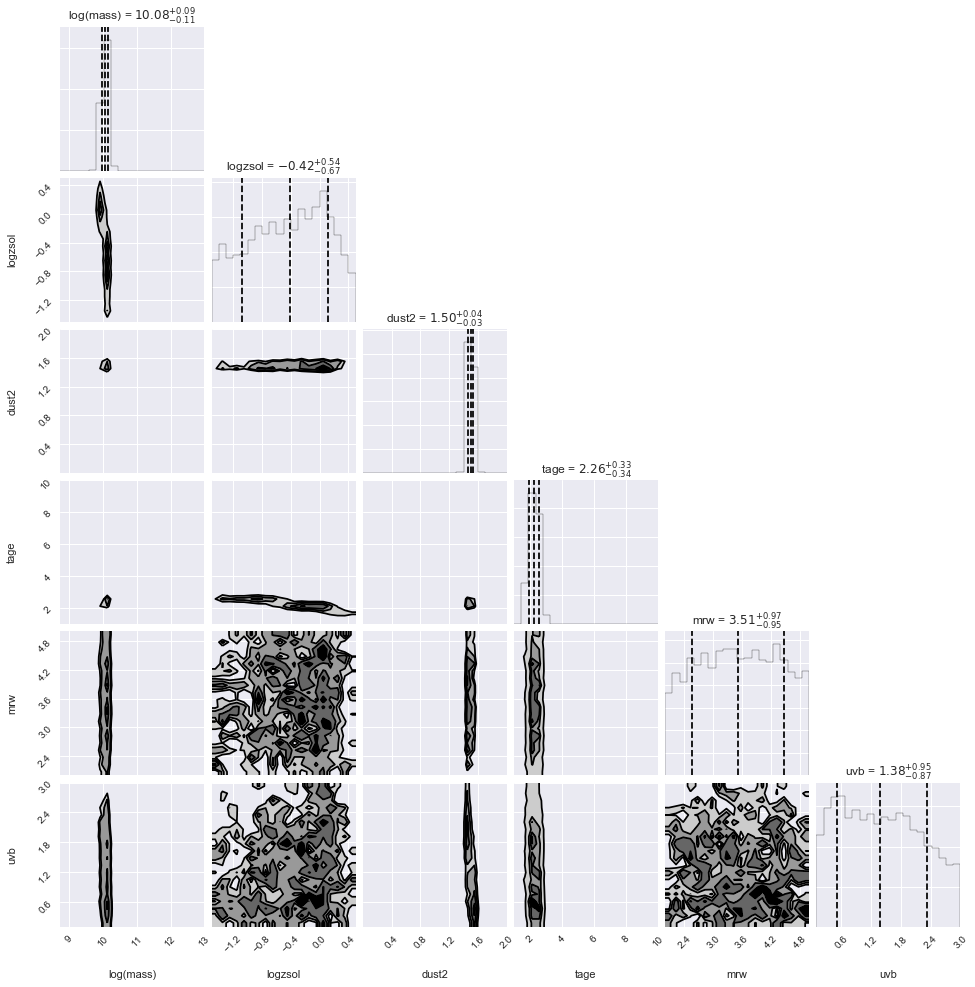

In [440]:
fig = pread.subcorner(resMW)

In [36]:
imaxp = np.argmax(respower['lnprobability'])
imaxC = np.argmax(resCal['lnprobability'])
imaxM = np.argmax(resMW['lnprobability'])
imaxK = np.argmax(resKC['lnprobability'])
theta_bestp = respower['chain'][imaxp, :].copy()
theta_bestC = resCal['chain'][imaxC, :].copy()
theta_bestM = resMW['chain'][imaxM, :].copy()
theta_bestK = resKC['chain'][imaxK, :].copy()

thetas = [theta_bestC, theta_bestK, theta_bestM, theta_bestp]

time = 2.0*u.Gyr
sfrs = []


#sps = build_sps()
#mod = build_model()
#spec, phot, mfracp = mod.mean_model(theta_bestp, obspower, sps)
#spec, phot, mfracC = modCal.mean_model(theta_bestC, obsCal, sps)
#spec, phot, mfracM = mod.mean_model(theta_bestM, obsMW, sps)
#spec, phot, mfracK = mod.mean_model(theta_bestK, obsKC, sps)

In [37]:
mKC = [item[0] for item in resKC['chain']]
mCal = [item[0] for item in resCal['chain']]
mMW = [item[0]  for item in resMW['chain']]
mpower = [item[0]  for item in respower['chain']]

In [40]:
time

<Quantity 2. Gyr>

In [52]:
massC = unc.Distribution(mCal*u.Msun)
massM = unc.Distribution(mMW*u.Msun)


ageC = unc.Distribution(ageCal*u.Gyr)
ageM = unc.Distribution(ageMW*u.Gyr)


sfrC = (massC.distribution / ageC.distribution.to(u.yr)) * time.to(u.yr)* np.exp(-time / (1.0*u.Gyr))

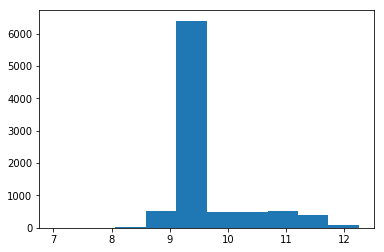

In [53]:
n, bins, _ = plt.hist(np.log10(sfrC.value))

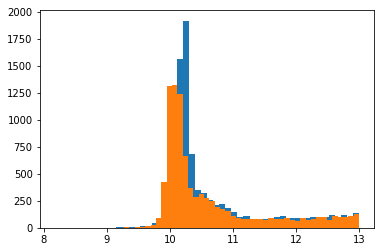

In [22]:

with quantity_support():
    plt.hist(test1.distribution, bins=50)
    plt.hist(test2.distribution, bins=50) 

In [23]:
test.pdf_percentiles([0.16, 0.5, 0.84])

array([9.36743568, 9.62391914, 9.74494897])

In [446]:
sfr_MW = (theta_bestM[0] / (theta_bestM[3] * 1.e9)) * 2.0 * np.exp(-2.0 / 1.0)
sfr_power = (theta_bestp[0] / (theta_bestp[3] * 1.e9)) * 2.0 * np.exp(-2.0 / 1.0)
sfr_Cal = (theta_bestC[0] / (theta_bestC[3] * 1.e9)) * 2.0 * np.exp(-2.0 / 1.0)
sfr_KC = (theta_bestK[0] / (theta_bestK[3] * 1.e9)) * 2.0 * np.exp(-2.0 / 1.0)

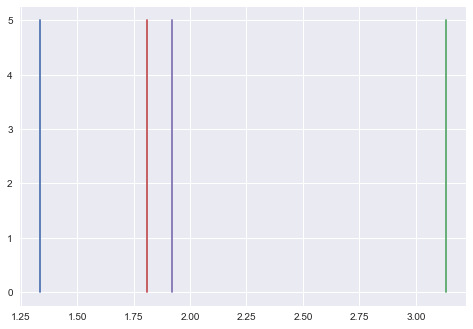

In [447]:
plt.plot([sfr_MW, sfr_MW], [0, 5])
plt.plot([sfr_power, sfr_power], [0, 5])
plt.plot([sfr_Cal, sfr_Cal], [0, 5])
plt.plot([sfr_KC, sfr_KC], [0, 5])

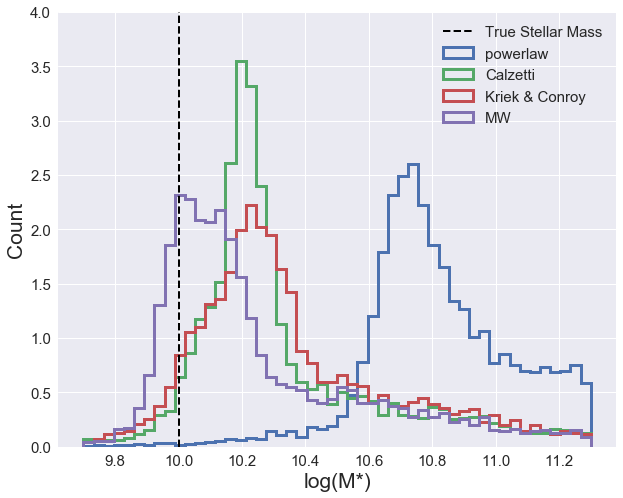

In [538]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(mpower, bins=50, range=(9.7, 11.3), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(mCal, bins=50, range=(9.7, 11.3), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(mKC, bins=50, range=(9.7, 11.3), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(mMW, bins=50, range=(9.7, 11.3), lw=3,histtype='step', density=True, label='MW')
plt.plot([10.0, 10.0], [0, 35], ls='--', lw=2, color='black', label = 'True Stellar Mass')

plt.xlabel('log(M*)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0, 4])
plt.legend(loc='best', fontsize=15)


plt.savefig('/Users/sidneylower/Documents/atten_test/mass_young.png', dpi=300)

In [24]:
zpower = [item[1] for item in respower['chain']]
zKC = [item[1] for item in resKC['chain']]
zCal = [item[1] for item in resCal['chain']]
zMW = [item[1] for item in resMW['chain']]

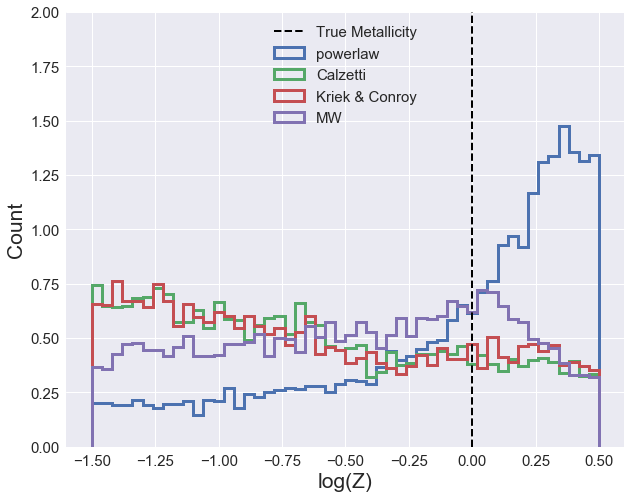

In [537]:
plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(zpower, bins=50, range=(-1.5, 0.5), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(zCal, bins=50, range=(-1.5, 0.5), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(zKC, bins=50, range=(-1.5, 0.5), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(zMW, bins=50, range=(-1.5, 0.5), lw=3,histtype='step', density=True, label='MW')
plt.plot([0.0, 0.0], [0, 35], ls='--', lw=2, color='black', label = 'True Metallicity')

plt.xlabel('log(Z)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0, 2])
plt.legend(loc='upper center', fontsize=15)
plt.savefig('/Users/sidneylower/Documents/atten_test/metal_young.png', dpi=300)

In [25]:
agepower = [item[3] for item in respower['chain']]
ageKC = [item[3] for item in resKC['chain']]
ageCal = [item[3] for item in resCal['chain']]
ageMW = [item[3] for item in resMW['chain']]


true_age = 2.0

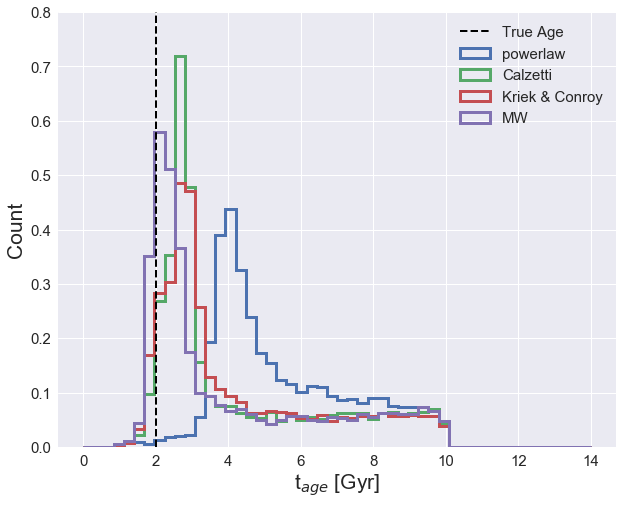

In [536]:
plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(agepower, bins=50, range=(0, 14.0), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(ageCal, bins=50, range=(0, 14.0), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(ageKC, bins=50, range=(0, 14.0), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(ageMW, bins=50, range=(0, 14.0), lw=3,histtype='step', density=True, label='MW')
plt.plot([true_age, true_age], [0, 35], ls='--', lw=2, color='black', label = 'True Age')

plt.xlabel('t$_{age}$ [Gyr]', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0, 0.8])
plt.legend(loc='upper right', fontsize=15)
plt.savefig('/Users/sidneylower/Documents/atten_test/age_young.png', dpi=300)

In [3]:
import fsps

In [4]:
sp = fsps.StellarPopulation(sfh=4,logzsol=0.0,dust_type=2,dust1=0.0,dust2=1.5, tage=2.0)
sp.params["sf_start"]= 1

In [427]:
sp.sfr * 1.e10 * 0.6

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


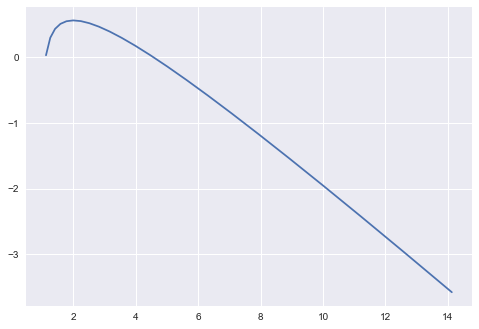

In [495]:
plt.plot(10**(sp.log_age) / 1.e9, np.log10(sp.sfr * 1.e10))

In [1]:
sp.sfr

NameError: name 'sp' is not defined

In [7]:
true_sfr = np.log10(sp.sfr * 1e10)

In [8]:
true_sfr

1.1437051204799538

In [384]:
taupower = [item[4] for item in respower['chain']]
tauKC = [item[4] for item in resKC['chain']]
tauCal = [item[4] for item in resCal['chain']]
tauMW = [item[4] for item in resMW['chain']]

In [533]:
mass_distrs = [mpower, mKC, mCal, mMW]
age_distrs = [agepower, ageKC, ageCal, ageMW]
#tau_distrs = [taupower, tauKC, tauCal, tauMW]

time = 1.0

sfrpower = []
sfrKC = []
sfrCal = []
sfrMW = []
for i in range(len(mpower)):
    sfrpower.append(np.log10((10**mpower[i] / (agepower[i]*1.e9)) * time *np.exp(-time / 1.0)))

for i in range(len(mKC)):
    sfrKC.append(np.log10((10**mKC[i] / (ageKC[i]*1.e9)) * time *np.exp(-time / 1.0)))
for i in range(len(mCal)):
    sfrCal.append(np.log10((10**mCal[i] / (ageCal[i]*1.e9)) * time *np.exp(-time / 1.0)))
for i in range(len(mMW)):
    sfrMW.append(np.log10((10**mMW[i] / (ageMW[i]*1.e9)) * time *np.exp(-time / 1.0)))


In [530]:
np.log10(1.e10 / 2.e9 * np.exp(-1.0))

0.264675522432767

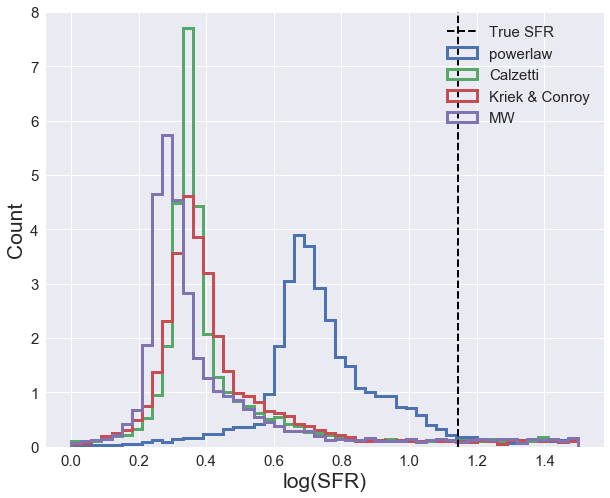

In [535]:
plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
labels = ['powerlaw', 'Kriek & Conroy', 'Calzetti', 'MW']
n, bins, _ = plt.hist(sfrpower, bins=50, range=(0., 1.5), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(sfrCal, bins=50, range=(0., 1.5), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(sfrKC, bins=50, range=(0., 1.5), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(sfrMW, bins=50, range=(0.0, 1.5), lw=3,histtype='step', density=True, label='MW')

plt.plot([true_sfr, true_sfr], [0, 35], ls='--', lw=2, color='black', label = 'True SFR')

plt.xlabel('log(SFR)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0, 8])
plt.legend(loc='upper right', fontsize=15)
plt.savefig('/Users/sidneylower/Documents/atten_test/sfr_young.png', dpi=300)

In [642]:
calzetti = [mCal, zCal, ageCal, sfrCal]
cardelli = [mMW, zMW, ageMW, sfrMW]
kriek_conroy = [mKC, zKC, ageKC, sfrKC]
powerlaw = [mpower, zpower, agepower, sfrpower]
keys = ['log(mass)', 'log(metallicity)', 'age', 'log(sfr)']

In [643]:
np.savez('/Users/sidneylower/Documents/attenuation_tests.npz', keys=keys, calzetti=calzetti, cardelli=cardelli, kriek_conroy=kriek_conroy, powerlaw=powerlaw)

In [640]:
test = np.load('/Users/sidneylower/Documents/attenuation_tests.npz')

In [550]:
list(test.keys())

['keys', 'calzetti', 'cardelli', 'kriek_conroy', 'powerlaw']

In [551]:
test['keys']

array(['mass', 'metallicity', 'age', 'sfr'], dtype='<U11')

In [641]:
test['calzetti']

array([[12.89441352, 12.39398514, 12.75204807, ..., 10.24929272,
        10.18988245, 10.30108443],
       [-0.09830908, -0.90275844, -1.39886363, ..., -1.28252465,
        -0.82875582, -1.48627395],
       [ 1.52185472,  1.20700152,  1.47879698, ...,  2.85588725,
         2.61039041,  2.99356491],
       [ 3.27774584,  2.87798284,  3.14784503, ...,  0.35925718,
         0.3388825 ,  0.39060127]])

In [561]:
mass_dict = {}
mass_dict['calzetti'] = calzetti[0]
mass_dict['cardelli'] = cardelli[0]
mass_dict['kriek_conroy'] = kriek_conroy[0]
mass_dict['powerlaw'] = powerlaw[0]

In [563]:
metal_dict = {}
metal_dict['calzetti'] = calzetti[1]
metal_dict['cardelli'] = cardelli[1]
metal_dict['kriek_conroy'] = kriek_conroy[1]
metal_dict['powerlaw'] = powerlaw[1]

In [564]:
age_dict = {}
age_dict['calzetti'] = calzetti[2]
age_dict['cardelli'] = cardelli[2]
age_dict['kriek_conroy'] = kriek_conroy[2]
age_dict['powerlaw'] = powerlaw[2]

In [565]:
sfr_dict = {}
sfr_dict['calzetti'] = calzetti[3]
sfr_dict['cardelli'] = cardelli[3]
sfr_dict['kriek_conroy'] = kriek_conroy[3]
sfr_dict['powerlaw'] = powerlaw[3]

In [566]:
full_dict = {}
full_dict['log(mass)'] = mass_dict
full_dict['log(metallicity)'] = metal_dict
full_dict['age'] = age_dict
full_dict['log(sfr)'] = sfr_dict

{'log(mass)': {'calzetti': [12.89441351953509,
   12.393985138135529,
   12.752048069382385,
   12.745770736015713,
   12.699451869602933,
   12.361144404727275,
   12.756657955787627,
   12.549392922467762,
   12.903224947363428,
   12.865261666575998,
   12.978524912379998,
   12.559599486424018,
   12.60713430520264,
   12.519436115537644,
   12.745021945569416,
   12.835272079556013,
   12.752950729591333,
   12.90383877804663,
   12.788498895753172,
   12.850931634962098,
   12.95578784538651,
   12.995576844545143,
   12.542984843067927,
   12.34414728754399,
   12.982763715346087,
   12.87145014452115,
   12.975430910492689,
   12.97808552908663,
   12.98771025104542,
   12.694097810956698,
   12.957747986025428,
   12.681537064393881,
   12.057492758524146,
   12.94622848369253,
   12.858574376336703,
   12.890170985653853,
   12.98264228205624,
   12.377596709039395,
   12.971379580874794,
   12.768646667391318,
   12.283907271511197,
   12.82640789436508,
   12.73053715351956

In [644]:
np.savez('/Users/sidneylower/Documents/attenuation_tests.npz', **full_dict)

In [1]:
import fsps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

In [97]:
sp = fsps.StellarPopulation(sfh=1,zcontinuous=1, dust1 = 2.0, dust2=0.2, logzsol=1.0)



In [98]:
wav, lum = sp.get_spectrum(tage=7)

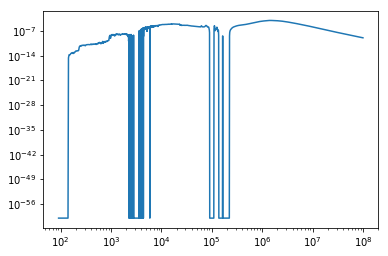

In [99]:
plt.loglog(wav, lum*1e10)
#plt.ylim([1e-7, 1e1])

In [100]:
np.savez('/Users/sidneylower/Documents/metal_test_1_dust1.npz', wav=wav, lum=lum)

In [104]:
Z_0 = np.load('/Users/sidneylower/Documents/metal_test_0_dust1.npz')
Z_dneg2 = np.load('/Users/sidneylower/Documents/metal_test_neg2_dust1.npz')
Z_neg05 = np.load('/Users/sidneylower/Documents/metal_test_neg05_dust1.npz')
Z_05 = np.load('/Users/sidneylower/Documents/metal_test_05_dust1.npz')
Z_d1 = np.load('/Users/sidneylower/Documents/metal_test_1_dust1.npz')

In [105]:
Z_neg2 = np.load('/Users/sidneylower/Documents/metal_test_neg2.npz')
Z_1 = np.load('/Users/sidneylower/Documents/metal_test_1.npz')

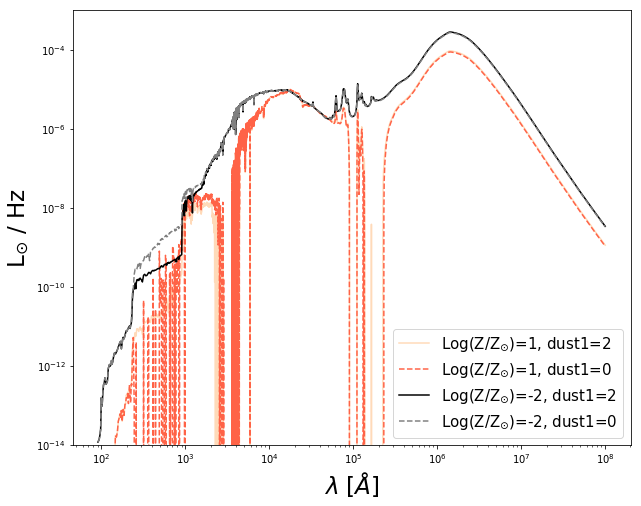

In [110]:
plt.figure(figsize=(10, 8))
plt.loglog(Z_d1['wav'], Z_d1['lum']*1e10, color='peachpuff', label='Log(Z/Z$_{\odot}$)=1, dust1=2')
plt.loglog(Z_1['wav'], Z_1['lum']*1e10, color='tomato', ls='--', label='Log(Z/Z$_{\odot}$)=1, dust1=0')

#plt.loglog(Z_05['wav'], Z_05['lum']*1e10, color='orange', label='Log(Z/Z$_{\odot}$) = 0.5')
#plt.loglog(Z_0['wav'], Z_0['lum']*1e10, color='steelblue', label='Log(Z/Z$_{\odot}$) = 0')
#plt.loglog(Z_neg05['wav'], Z_neg05['lum']*1e10, color='midnightblue', label='Log(Z/Z$_{\odot}$) = -0.5')
plt.loglog(Z_dneg2['wav'], Z_dneg2['lum']*1e10, color='black', label='Log(Z/Z$_{\odot}$)=-2, dust1=2')

plt.loglog(Z_neg2['wav'], Z_neg2['lum']*1e10, color='gray', ls='--', label='Log(Z/Z$_{\odot}$)=-2, dust1=0')


plt.ylim([1e-14, 1e-3])

plt.ylabel('L$_{\odot}$ / Hz', fontsize=23)
plt.xlabel('$\lambda$ [$\AA$]', fontsize=23)

plt.legend(loc='lower right', fontsize=15)

#plt.annotate('Dust1 = 2.0', xy=(2e6, 1e-10), fontsize=15)
plt.savefig('/Users/sidneylower/Documents/prosp_final_plots/SEDs/fsps_ref_dustcomp.png', dpi=300)